In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

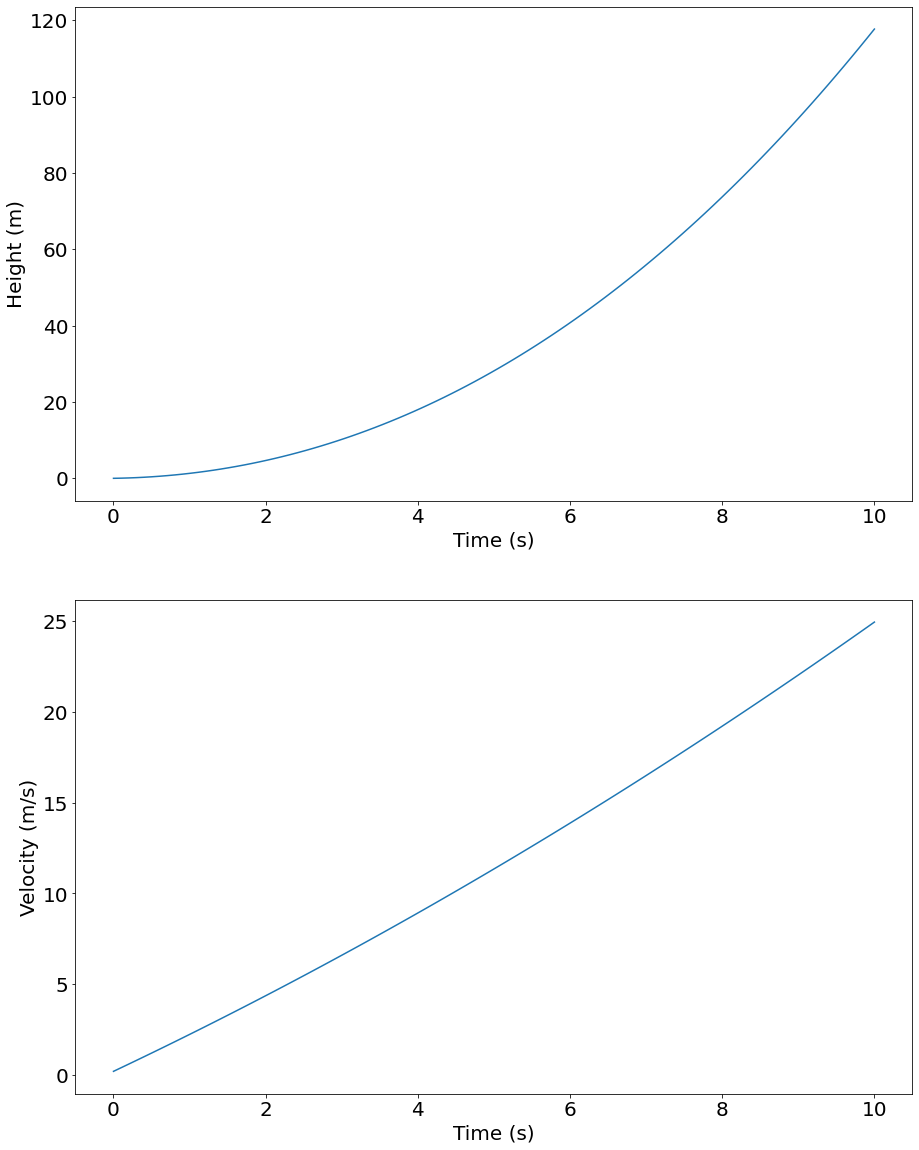

In [2]:
# Define the scenario.

dt = 0.1  # Time step
n = 100   # Duration (in time steps)
t = np.linspace(0, dt * n, n)
commanded_acceleration = 2 + 0.01 * np.arange(n)  # Linearly increasing acceleration
true_acceleration = commanded_acceleration.copy()

true_velocity = np.cumsum(true_acceleration * dt)  # Integrate acceleration to get velocity
true_height = np.cumsum(true_velocity * dt)  # Integrate velocity to get height

plt.figure(figsize=(15, 20))
plt.rc("font", size=20)
plt.subplot(2, 1, 1)
plt.plot(t, true_height, label="Height")
plt.ylabel("Height (m)")
plt.xlabel("Time (s)")
plt.subplot(2, 1, 2)
plt.plot(t, true_velocity, label="Velocity")
plt.ylabel("Velocity (m/s)")
plt.xlabel("Time (s)")
plt.show()

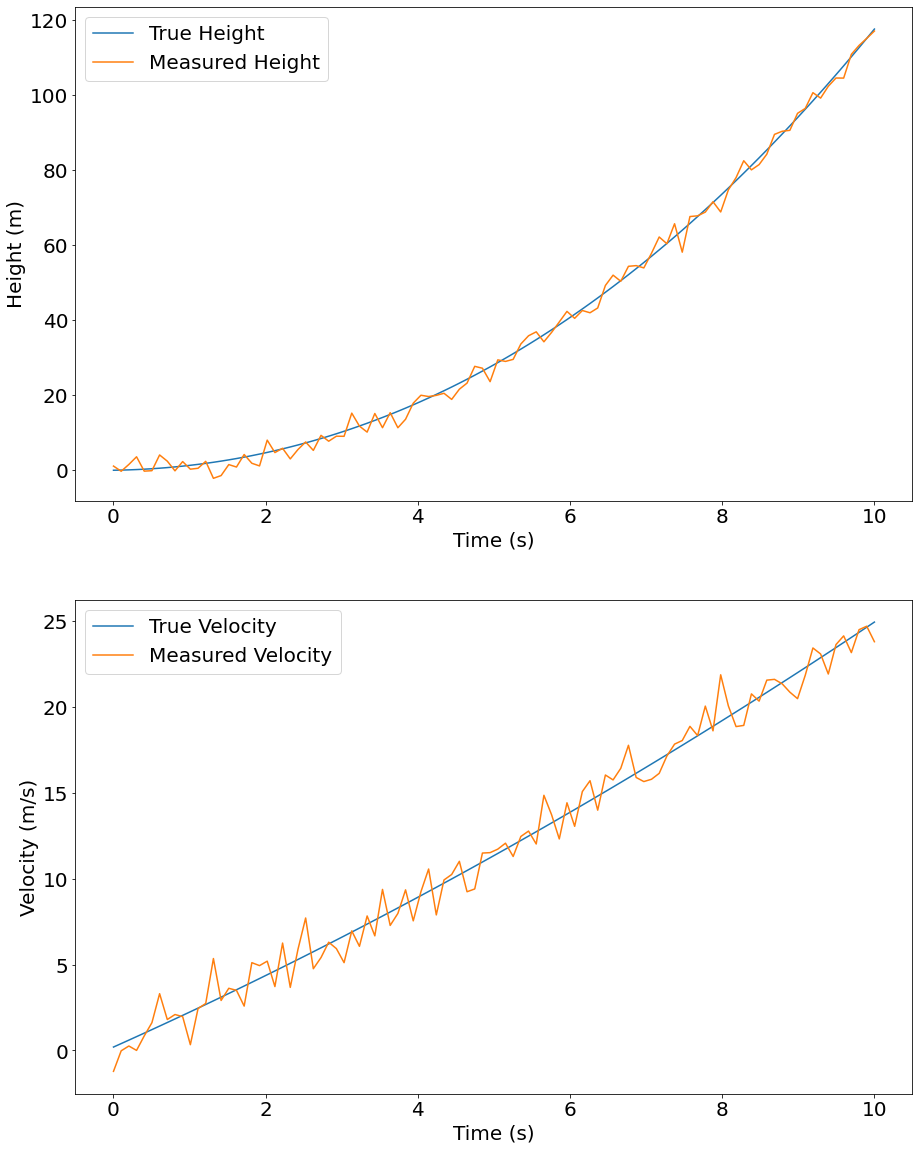

RMS Error Height (m)
  Sensor:    2.034 m (RMS)
RMS Error Velocity (m/s):
  Sensor:    0.949 m/s (RMS)


In [3]:
# Sensors only.

height_variance = 5
velocity_variance = 1

height_measurements = true_height + np.random.normal(0, np.sqrt(height_variance), n)
velocity_measurements = true_velocity + np.random.normal(0, np.sqrt(velocity_variance), n)

height_measurement_error = true_height - height_measurements
velocity_measurement_error = true_velocity - velocity_measurements
height_measurement_rms_error = np.sqrt(np.mean(height_measurement_error**2))
velocity_measurement_rms_error = np.sqrt(np.mean(velocity_measurement_error**2))

plt.figure(figsize=(15, 20))
plt.rc("font", size=20)
plt.subplot(2, 1, 1)
plt.plot(t, true_height, label="True Height")
plt.plot(t, height_measurements, label="Measured Height")
plt.legend()
plt.ylabel("Height (m)")
plt.xlabel("Time (s)")
plt.subplot(2, 1, 2)
plt.plot(t, true_velocity, label="True Velocity")
plt.plot(t, velocity_measurements, label="Measured Velocity")
plt.legend()
plt.ylabel("Velocity (m/s)")
plt.xlabel("Time (s)")
plt.show()

print("RMS Error Height (m)")
print(f"  Sensor:    {height_measurement_rms_error:0.3f} m (RMS)")
print("RMS Error Velocity (m/s):")
print(f"  Sensor:    {velocity_measurement_rms_error:0.3f} m/s (RMS)")

In [4]:
class KalmanFilter:
    
    def __init__(self):
        pass
    
    @staticmethod
    def _prediction_step(x, P, u, A, B, Q):
        x = A @ x + B * u
        P = A @ P @ A.T + Q
        return x, P
    
    @staticmethod
    def _correction_step(x, P, z, H, R):
        y = z - H @ x
        S = H @ P @ H.T + R
        K = P @ H.T @ np.linalg.inv(S)
        x = x + K @ y
        P = (np.eye(len(x)) - K @ H) @ P
        return x, P
    
    def estimate(self, measurements, control_inputs, A, B, Q, H, R, x_init, P_init):
        estimates = np.empty_like(measurements)
        estimates_cov = np.empty_like(measurements)
        estimates[0] = x_init.flatten()
        estimates_cov[0] = [P_init[0, 0], P_init[1, 1]]
        x, P = x_init, P_init
        for k in range(1, n):
            u = 0 if control_inputs is None else control_inputs[k-1]
            z = measurements[k, :, np.newaxis]  # np.newaxis because we need shape (n, 1) not (n,)
            x, P = self._prediction_step(x, P, u, A, B, Q)
            x, P = self._correction_step(x, P, z, H, R)
            estimates[k] = x.flatten()
            estimates_cov[k] = [P[0, 0], P[1, 1]]
        return estimates, estimates_cov
    
    @staticmethod
    def plot(t, ground_truth, measurements, estimates, estimates_cov, state_variable_names):
        state_dim = ground_truth.shape[1]
        plt.figure(figsize=(15, 10 * state_dim))
        plt.rc("font", size=20)
        for i in range(state_dim):
            plt.subplot(state_dim, 1, i+1)
            plt.title(f"{state_variable_names[i]} Estimation")
            plt.plot(t, ground_truth[:,i], label=f"True {state_variable_names[i]}", color="blue")
            plt.plot(t, measurements[:,i], label=f"Measured {state_variable_names[i]}", color="orange")
            plt.plot(t, estimates[:,i], label=f"Estimated {state_variable_names[i]}", color="green")
            plt.fill_between(t, estimates[:,i] - np.sqrt(estimates_cov[:,i]),
                             estimates[:,i] + np.sqrt(estimates_cov[:,i]),
                             label="Estimate +/- 1 std. dev.", alpha=0.2, color="green")
            plt.legend()
            plt.xlabel("Time (s)")
            plt.ylabel(f"{state_variable_names[i]}")
        plt.show()
    
    @staticmethod
    def display_errors(ground_truth, measurements, estimates, state_variable_names):
        state_dim = ground_truth.shape[1]
        for i in range(state_dim):
            # NOTE: Ignore initial state estimate to allow estimator one time step
            #       to converge. Otherwise a bad initial estimate will make the
            #       calculated error huge. (RMS is very sensitive to outliers.)
            sensor_rms = np.sqrt(np.mean((ground_truth[1:,i] - measurements[1:,i])**2))
            estimator_rms = np.sqrt(np.mean((ground_truth[1:,i] - estimates[1:,i])**2))
            print(f"RMS Error {state_variable_names[i]}:")
            print(f"  Sensor:    {sensor_rms:0.3f}")
            print(f"  Estimator: {estimator_rms:0.3f}")
    
    def simulate(self, ground_truth, measurements, state_variable_names,
                 control_inputs, t, A, B, Q, H, R, x_init, P_init):
        estimates, estimates_cov = self.estimate(measurements, control_inputs, A, B, Q, H, R, x_init, P_init)
        
        self.plot(t, ground_truth, measurements, estimates, estimates_cov, state_variable_names)

        self.display_errors(ground_truth, measurements, estimates, state_variable_names)

In [5]:
# Define the ground truth for our simulation.
dt = 0.1  # Time step
n = 100   # Duration (in time steps)
t = np.linspace(0, dt * n, n)
commanded_acceleration = 1 + 0.01 * np.arange(n)
true_acceleration = commanded_acceleration.copy()
true_velocity = np.cumsum(true_acceleration * dt)  # Integrate acceleration to get velocity
true_height = np.cumsum(true_velocity * dt)  # Integrate velocity to get height

# Generate simulated sensor readings.
height_variance = 5
velocity_variance = 1
height_measurements = true_height + np.random.normal(0, np.sqrt(height_variance), n)
velocity_measurements = true_velocity + np.random.normal(0, np.sqrt(velocity_variance), n)

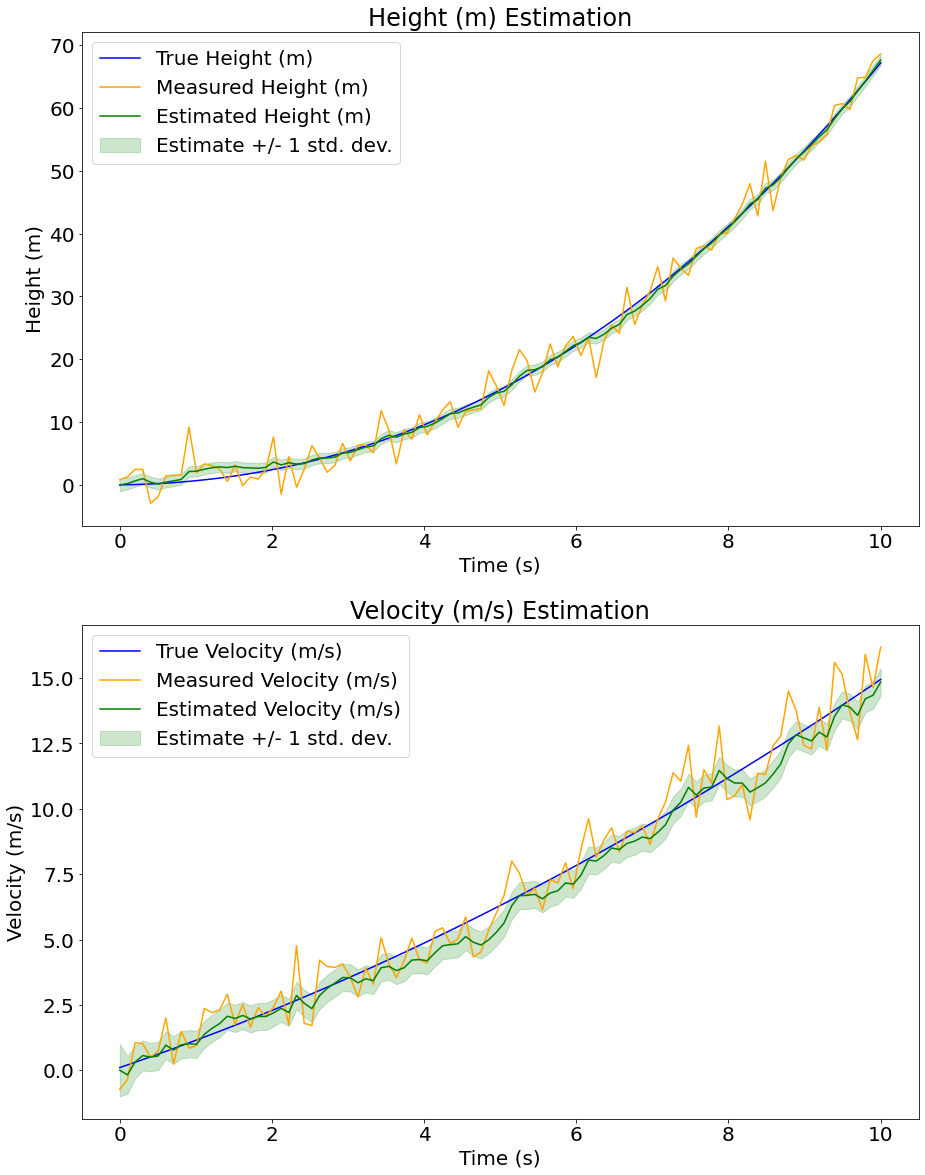

RMS Error Height (m):
  Sensor:    2.428
  Estimator: 0.645
RMS Error Velocity (m/s):
  Sensor:    0.887
  Estimator: 0.463


In [6]:
### Simulation #0
#
# In this simulation we start with measurements but no control input.

# Define our state transition matrix.
A = np.array([[1, dt],
              [0, 1 ]])

# Define our control input matrix.
B = np.array([[0.5 * dt**2],
              [dt]])

# Define our process noise covariance matrix.
Q = np.array([[0.1, 0],
              [0, 0.1]])

# Define our observation matrix.
H = np.array([[1, 0],
              [0, 1]])

# Define our measurement noise covariance matrix.
R = np.array([[height_variance, 0                ],
              [0,               velocity_variance]])

# Initial estimates.
x_init = np.array([[0],
                   [0]])
P_init = np.array([[1, 0],
                   [0, 1]])

# Construct our estimator and run it in simulation.
kf = KalmanFilter()
kf.simulate(
    ground_truth=np.vstack((true_height, true_velocity)).T,
    measurements=np.vstack((height_measurements, velocity_measurements)).T,
    state_variable_names=["Height (m)", "Velocity (m/s)"],
    control_inputs=None,
    t=t, A=A, B=B, Q=Q, H=H, R=R, x_init=x_init, P_init=P_init
)

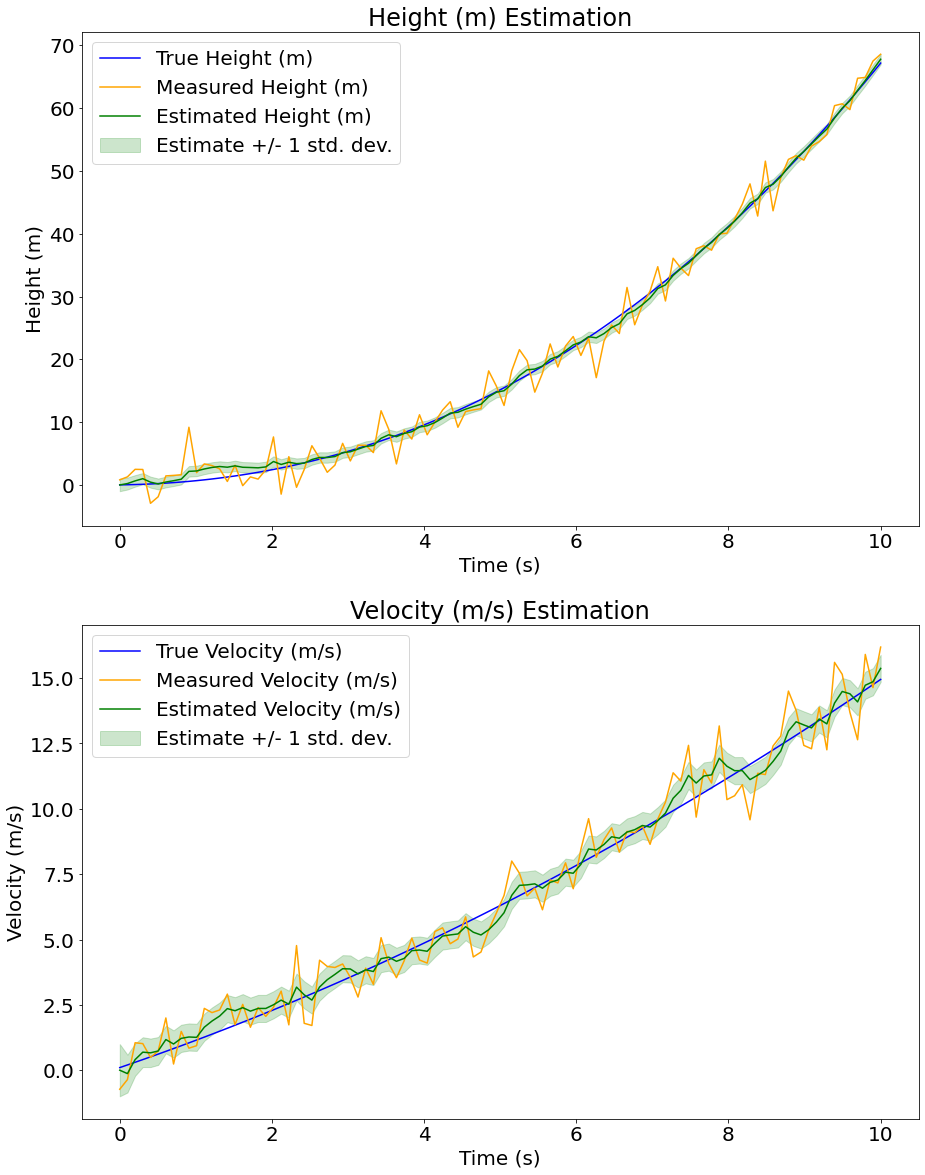

RMS Error Height (m):
  Sensor:    2.428
  Estimator: 0.638
RMS Error Velocity (m/s):
  Sensor:    0.887
  Estimator: 0.363


In [7]:
### Simulation #1
#
# In this simulation we add control inputs.

# Define our state transition matrix.
A = np.array([[1, dt],
              [0, 1 ]])

# Define our control input matrix.
B = np.array([[0.5 * dt**2],
              [dt]])

# Define our process noise covariance matrix.
Q = np.array([[0.1, 0],
              [0, 0.1]])

# Define our observation matrix.
H = np.array([[1, 0],
              [0, 1]])

# Define our measurement noise covariance matrix.
R = np.array([[height_variance, 0                ],
              [0,               velocity_variance]])

# Initial estimates.
x_init = np.array([[0],
                   [0]])
P_init = np.array([[1, 0],
                   [0, 1]])

# Construct our estimator and run it in simulation.
kf = KalmanFilter()
kf.simulate(
    ground_truth=np.vstack((true_height, true_velocity)).T,
    measurements=np.vstack((height_measurements, velocity_measurements)).T,
    state_variable_names=["Height (m)", "Velocity (m/s)"],
    control_inputs=commanded_acceleration,
    t=t, A=A, B=B, Q=Q, H=H, R=R, x_init=x_init, P_init=P_init
)

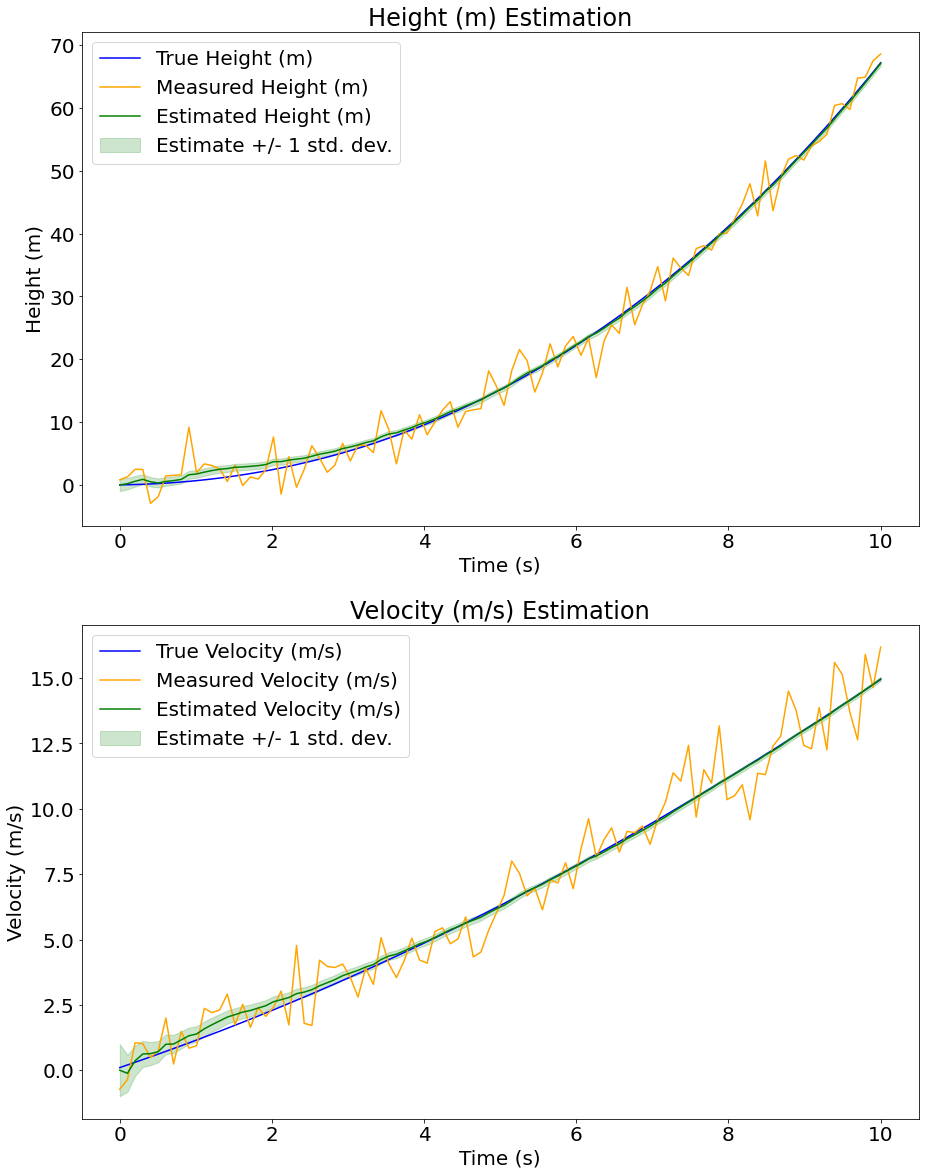

RMS Error Height (m):
  Sensor:    2.428
  Estimator: 0.554
RMS Error Velocity (m/s):
  Sensor:    0.887
  Estimator: 0.152


In [8]:
### Simulation #2
#
# This simulation is the same as #1, except that we've dramatically reduced our process
# covariance, leading our estimator to trust its state predictions with extreme
# confidence. Since we actually have no process noise (true acceleration is equal to
# commanded acceleration), this works *really* well.

# Define our state transition matrix.
A = np.array([[1, dt],
              [0, 1 ]])

# Define our control input matrix.
B = np.array([[0.5 * dt**2],
              [dt]])

# Define our process noise covariance matrix.
Q = np.array([[0.0001, 0     ],
              [0,      0.0001]])

# Define our observation matrix.
H = np.array([[1, 0],
              [0, 1]])

# Define our measurement noise covariance matrix.
R = np.array([[height_variance, 0                ],
              [0,               velocity_variance]])

# Initial estimates.
x_init = np.array([[0],
                   [0]])
P_init = np.array([[1, 0],
                   [0, 1]])

# Construct our estimator and run it in simulation.
kf = KalmanFilter()
kf.simulate(
    ground_truth=np.vstack((true_height, true_velocity)).T,
    measurements=np.vstack((height_measurements, velocity_measurements)).T,
    state_variable_names=["Height (m)", "Velocity (m/s)"],
    control_inputs=commanded_acceleration,
    t=t, A=A, B=B, Q=Q, H=H, R=R, x_init=x_init, P_init=P_init
)

In [9]:
# Define the ground truth for our simulation.
dt = 0.1  # Time step
n = 100   # Duration (in time steps)
t = np.linspace(0, dt * n, n)
commanded_acceleration = 1 + 0.01 * np.arange(n)
true_acceleration = commanded_acceleration.copy()
true_acceleration[20:40] = 0  # Simulate 2 second failure of our rocket engine
true_velocity = np.cumsum(true_acceleration * dt)  # Integrate acceleration to get velocity
true_height = np.cumsum(true_velocity * dt)  # Integrate velocity to get height

# Generate simulated sensor readings.
height_variance = 5
velocity_variance = 1
height_measurements = true_height + np.random.normal(0, np.sqrt(height_variance), n)
velocity_measurements = true_velocity + np.random.normal(0, np.sqrt(velocity_variance), n)

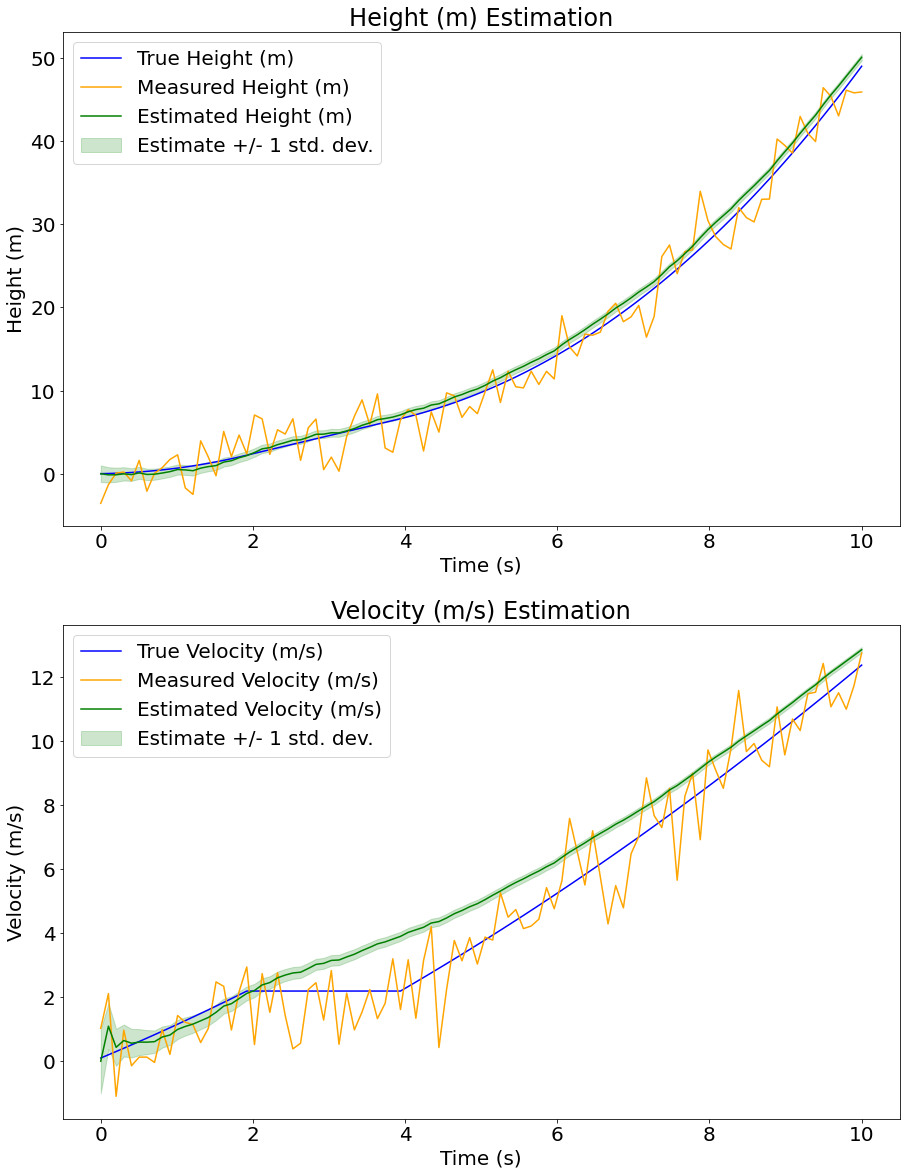

RMS Error Height (m):
  Sensor:    2.355
  Estimator: 0.823
RMS Error Velocity (m/s):
  Sensor:    0.926
  Estimator: 0.897


In [10]:
### Simulation #3
#
# This simulation shows the danger of trusting our process model too heavily. We simulate
# an acuator failure by setting the true acceleration to zero for a few time steps, which
# means that our true acceleration is not always equal to commanded acceleration. Our
# estimator's extreme faith in its predictions makes it very slow to correct for this
# anomaly.

# Define our state transition matrix.
A = np.array([[1, dt],
              [0, 1 ]])

# Define our control input matrix.
B = np.array([[0.5 * dt**2],
              [dt]])

# Define our process noise covariance matrix.
Q = np.array([[0.0001, 0     ],
              [0,      0.0001]])

# Define our observation matrix.
H = np.array([[1, 0],
              [0, 1]])

# Define our measurement noise covariance matrix.
R = np.array([[height_variance, 0                ],
              [0,               velocity_variance]])

# Initial estimates.
x_init = np.array([[0],
                   [0]])
P_init = np.array([[1, 0],
                   [0, 1]])

# Construct our estimator and run it in simulation.
kf = KalmanFilter()
kf.simulate(
    ground_truth=np.vstack((true_height, true_velocity)).T,
    measurements=np.vstack((height_measurements, velocity_measurements)).T,
    state_variable_names=["Height (m)", "Velocity (m/s)"],
    control_inputs=commanded_acceleration,
    t=t, A=A, B=B, Q=Q, H=H, R=R, x_init=x_init, P_init=P_init
)

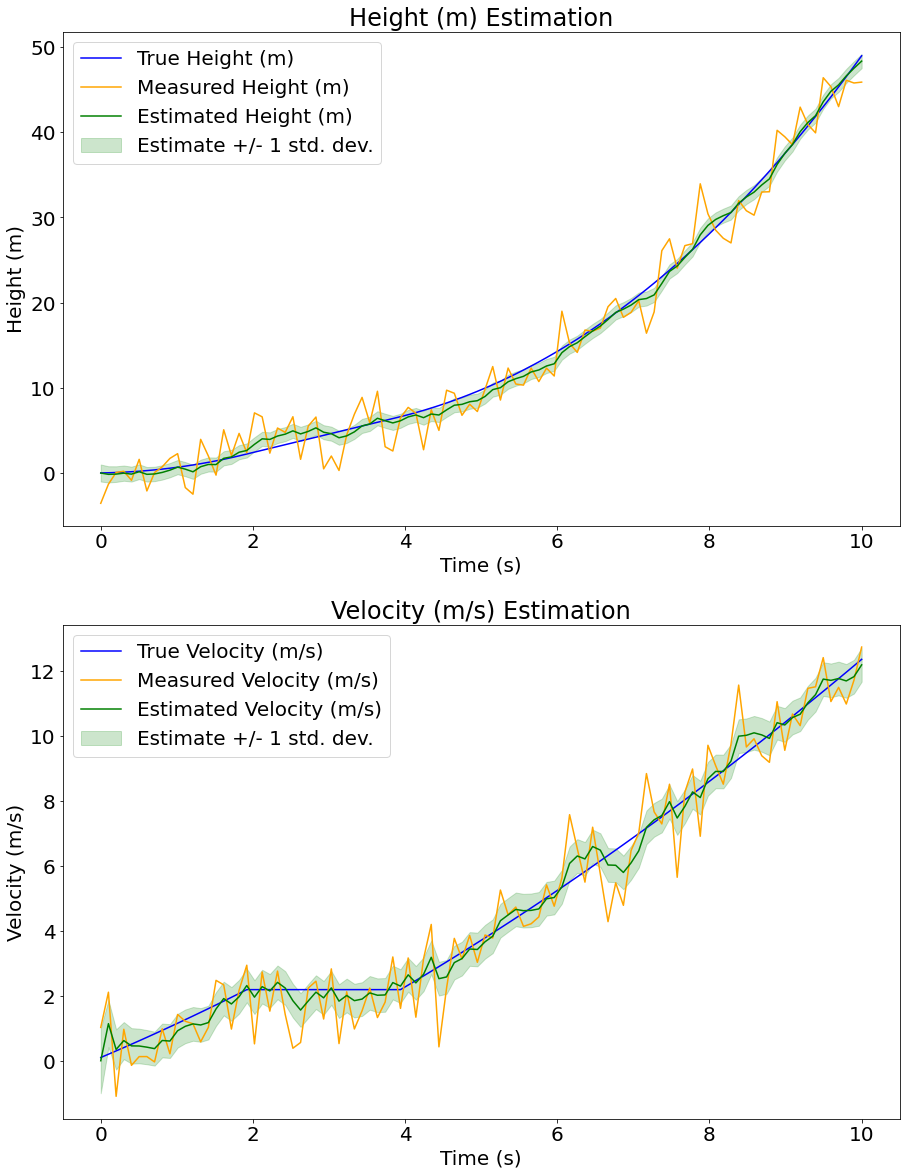

RMS Error Height (m):
  Sensor:    2.355
  Estimator: 0.639
RMS Error Velocity (m/s):
  Sensor:    0.926
  Estimator: 0.311


In [11]:
### Simulation #4
#
# In this simulation we make our estimator more robust to process noise by increasing the
# process covariance. While this makes us more susceptible to sensor noise, it improves our
# overall performance by helping our estimator recover more quickly from the process
# anomaly.

# Define our state transition matrix.
A = np.array([[1, dt],
              [0, 1 ]])

# Define our control input matrix.
B = np.array([[0.5 * dt**2],
              [dt]])

# Define our process noise covariance matrix.
Q = np.array([[0.1, 0  ],
              [0,   0.1]])

# Define our observation matrix.
H = np.array([[1, 0],
              [0, 1]])

# Define our measurement noise covariance matrix.
R = np.array([[height_variance, 0                ],
              [0,               velocity_variance]])

# Initial estimates.
x_init = np.array([[0],
                   [0]])
P_init = np.array([[1, 0],
                   [0, 1]])

# Construct our estimator and run it in simulation.
kf = KalmanFilter()
kf.simulate(
    ground_truth=np.vstack((true_height, true_velocity)).T,
    measurements=np.vstack((height_measurements, velocity_measurements)).T,
    state_variable_names=["Height (m)", "Velocity (m/s)"],
    control_inputs=commanded_acceleration,
    t=t, A=A, B=B, Q=Q, H=H, R=R, x_init=x_init, P_init=P_init
)

In [12]:
# Define the ground truth for our simulation.
dt = 0.1  # Time step
n = 100   # Duration (in time steps)
t = np.linspace(0, dt * n, n)
commanded_acceleration = 1 + 0.01 * np.arange(n)
true_acceleration = commanded_acceleration.copy()
true_velocity = np.cumsum(true_acceleration * dt)  # Integrate acceleration to get velocity
true_height = np.cumsum(true_velocity * dt)  # Integrate velocity to get height

# Generate simulated sensor readings.
height_variance = 5
velocity_variance = 1
height_measurements = true_height + np.random.normal(0, np.sqrt(height_variance), n)
velocity_measurements = true_velocity + np.random.normal(0, np.sqrt(velocity_variance), n)

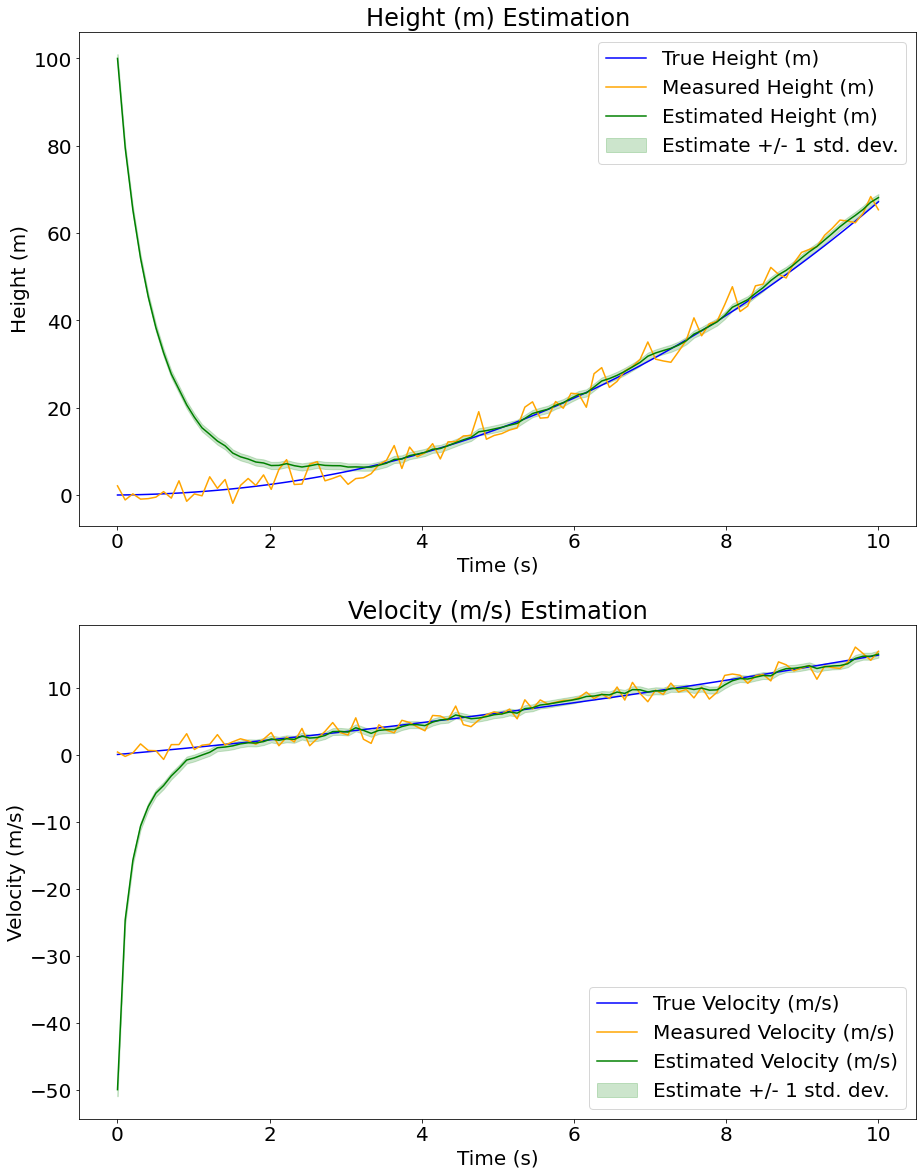

RMS Error Height (m):
  Sensor:    2.147
  Estimator: 14.575
RMS Error Velocity (m/s):
  Sensor:    0.968
  Estimator: 3.444


In [13]:
### Simulation #5
#
# Here we start with a bad initial state estimate. Note that even though the process
# covariance is fairly large, as in #4, it takes a little time for our estimator to
# converge. This is because our initial state covariance estimate is low, which reflects
# high confidence in our initial state estimate.

# Define the ground truth for our simulation.
dt = 0.1  # Time step
n = 100   # Duration (in time steps)
t = np.linspace(0, dt * n, n)
commanded_acceleration = 1 + 0.01 * np.arange(n)
true_acceleration = commanded_acceleration.copy()
true_velocity = np.cumsum(true_acceleration * dt)  # Integrate acceleration to get velocity
true_height = np.cumsum(true_velocity * dt)  # Integrate velocity to get height

# Generate simulated sensor readings.
height_variance = 5
velocity_variance = 1
height_measurements = true_height + np.random.normal(0, np.sqrt(height_variance), n)
velocity_measurements = true_velocity + np.random.normal(0, np.sqrt(velocity_variance), n)

# Define our state transition matrix.
A = np.array([[1, dt],
              [0, 1 ]])

# Define our control input matrix.
B = np.array([[0.5 * dt**2],
              [dt]])

# Define our process noise covariance matrix.
Q = np.array([[0.1, 0  ],
              [0,   0.1]])

# Define our observation matrix.
H = np.array([[1, 0],
              [0, 1]])

# Define our measurement noise covariance matrix.
R = np.array([[height_variance, 0                ],
              [0,               velocity_variance]])

# Initial estimates.
x_init = np.array([[100],
                   [-50]])
P_init = np.array([[1, 0],
                   [0, 1]])

# Construct our estimator and run it in simulation.
kf = KalmanFilter()
kf.simulate(
    ground_truth=np.vstack((true_height, true_velocity)).T,
    measurements=np.vstack((height_measurements, velocity_measurements)).T,
    state_variable_names=["Height (m)", "Velocity (m/s)"],
    control_inputs=commanded_acceleration,
    t=t, A=A, B=B, Q=Q, H=H, R=R, x_init=x_init, P_init=P_init
)

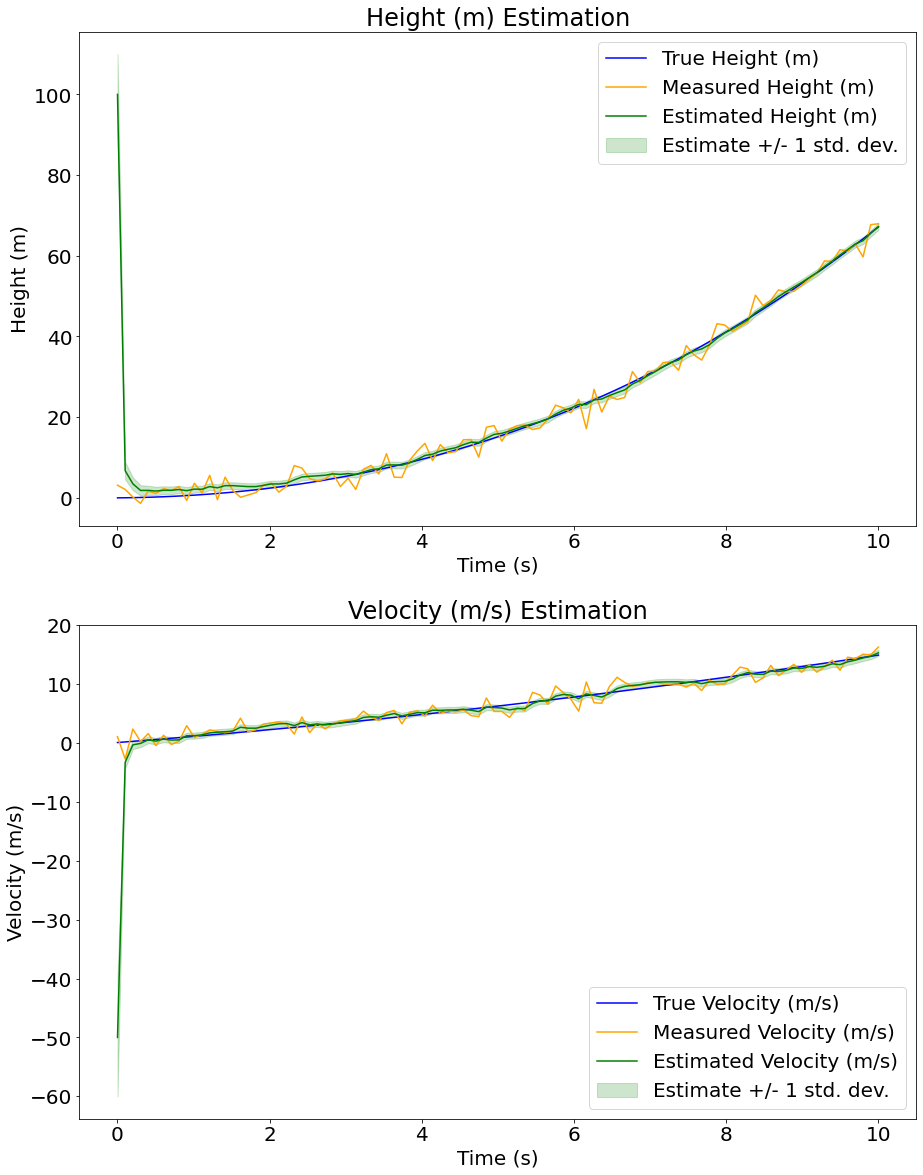

RMS Error Height (m):
  Sensor:    2.132
  Estimator: 1.109
RMS Error Velocity (m/s):
  Sensor:    1.110
  Estimator: 0.561


In [14]:
### Simulation #6
#
# We can indicate low confidence in our initial state estimate by increasing the initial
# state covariance estimate. This makes the estimator converge more quickly, without
# affecting the steady-state behavior. Note that the initial state estimate is ignored
# when computing RMS error.

# Define the ground truth for our simulation.
dt = 0.1  # Time step
n = 100   # Duration (in time steps)
t = np.linspace(0, dt * n, n)
commanded_acceleration = 1 + 0.01 * np.arange(n)
true_acceleration = commanded_acceleration.copy()
true_velocity = np.cumsum(true_acceleration * dt)  # Integrate acceleration to get velocity
true_height = np.cumsum(true_velocity * dt)  # Integrate velocity to get height

# Generate simulated sensor readings.
height_variance = 5
velocity_variance = 1
height_measurements = true_height + np.random.normal(0, np.sqrt(height_variance), n)
velocity_measurements = true_velocity + np.random.normal(0, np.sqrt(velocity_variance), n)

# Define our state transition matrix.
A = np.array([[1, dt],
              [0, 1 ]])

# Define our control input matrix.
B = np.array([[0.5 * dt**2],
              [dt]])

# Define our process noise covariance matrix.
Q = np.array([[0.1, 0  ],
              [0,   0.1]])

# Define our observation matrix.
H = np.array([[1, 0],
              [0, 1]])

# Define our measurement noise covariance matrix.
R = np.array([[height_variance, 0                ],
              [0,               velocity_variance]])

# Initial estimates.
x_init = np.array([[100],
                   [-50]])
P_init = np.array([[100, 0 ],
                   [0,  100]])

# Construct our estimator and run it in simulation.
kf = KalmanFilter()
kf.simulate(
    ground_truth=np.vstack((true_height, true_velocity)).T,
    measurements=np.vstack((height_measurements, velocity_measurements)).T,
    state_variable_names=["Height (m)", "Velocity (m/s)"],
    control_inputs=commanded_acceleration,
    t=t, A=A, B=B, Q=Q, H=H, R=R, x_init=x_init, P_init=P_init
)